In [1]:
%matplotlib notebook
from astropy.coordinates import SkyCoord
from astropy.io import ascii
from astroquery.irsa_dust import IrsaDust
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.integrate import quad
from scipy.optimize import curve_fit
import sncosmo
import sys
import tables
from matplotlib.ticker import MultipleLocator

if sys.version_info.major != 3:
    raise RuntimeError("This notebook only works for python 3")

In [2]:
# parameters for 16abc

T0 = 57499.54
z = 0.0234

markers = {"Swift": "h", 
           "P48": "o",
           "P60": "d",
           "LCO-1m": "s"}

AAMcolors = {'Ni_models': "#2A3132",
             'g': "LightSeaGreen", 
             'UVW2-V': "#061283", # ultramarine
             'UVW1-V': "#00CFAA", # cyan
             'U-V': "#4897D8", # electric blue
             'B-V': "#89DA59", # spring green
             'g-r': "#F9DC24", # sunset #F77604", # caviar
             'r-i': "#FF0038"  # ripe tomato
            }

In [3]:
# iPTF16abc data
h5file = tables.open_file("iPTF16abc.h5", mode="r")
table = h5file.root.photometry

# P48 - discovery data
g_PTF = np.array([((row["time"] - T0)/(1+z), row["flux"], row["flux_err"])
                 for row in h5file.root.photometry
                 if ((row["filter_name"] == b"g") & (row["telescope"] == b"P48"))],
                dtype=[("time", "f"), ("flux", "f"), ("flux_err", "f")])
g_PTF.sort(order="time")
idx = np.logical_and(g_PTF["time"] > -21, g_PTF["time"] < -14)
early_lc = g_PTF[idx]

# all g-band data for plot
g_lc = np.array([((row["time"] - T0)/(1+z), row["flux"], row["flux_err"], row["telescope"])
                 for row in h5file.root.photometry
                 if (row["filter_name"] == b"g") ],
                dtype=[("time", "f"), ("flux", "f"), ("flux_err", "f"), ("telescope", "a9")])
g_lc.sort(order="time")

In [4]:
# fit the early light curve
def EarlyLCModel(t, t0, alpha, C):
    return np.where(t > t0, 10**(C) * (t - t0)**alpha, 0)

In [5]:
# set searching grids
t0_range = np.linspace(-19, -17, 201)
alpha_range = np.linspace(0.5, 2.5, 101)
C_range = np.linspace(-6, -3, 301)
X, Y, Z = np.meshgrid(t0_range, alpha_range, C_range)
chi2 = np.zeros(X.shape)
timegrid = np.ones(X.shape)
for t, f, ferr in zip(early_lc["time"], early_lc["flux"], early_lc["flux_err"]):
    chi2 += ((f - EarlyLCModel(t * timegrid, X, Y, Z))/ferr)**2
chi2 -= np.min(chi2)
idx = np.where(chi2 == 0.0)
best_fit = {"t0": X[idx], "alpha": Y[idx], "C": Z[idx]}
print(best_fit)

/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in power
  app.launch_new_instance()


{'t0': array([-17.91]), 'alpha': array([ 0.98]), 'C': array([-4.22])}


In [6]:
print("First obs was {:.4f} d after first light".format(g_lc['time'][6] - best_fit['t0'][0]))

First obs was 0.1500 d after first light


In [7]:
# determine probability contours
prob = np.sum(np.exp(-chi2 / 2), axis=2)
prob /= np.sum(prob)
X_2D, Y_2D = np.meshgrid(t0_range, alpha_range)

flat_prob = prob.flatten()
flat_prob.sort()
total = 0
one_sigma = -1
three_sigma = -1
for num in flat_prob[::-1]:
    total += num
    if one_sigma < 0 and total > 0.68:
        one_sigma = num
    if three_sigma < 0 and total > 0.997:
        three_sigma = num

In [8]:
# determine the 1D probability CI

# t0
prob_1D = np.sum(prob, axis = 0)
prob_1D /= np.sum(prob_1D)

cumsum = np.cumsum(prob_1D)
print("""The 68% C.I. on t0 is: 
        {:.4f} + {:.4f} - {:.4f}""".format(best_fit['t0'][0], 
                                           t0_range[np.argmin(np.abs(cumsum - .84))] - best_fit['t0'][0],
                                           best_fit['t0'][0] - t0_range[np.argmin(np.abs(cumsum - .16))]))
print("""The 95% C.I. on t0 is: 
        {:.4f} + {:.4f} - {:.4f}""".format(best_fit['t0'][0], 
                                           t0_range[np.argmin(np.abs(cumsum - .975))] - best_fit['t0'][0],
                                           best_fit['t0'][0] - t0_range[np.argmin(np.abs(cumsum - .025))]))
print("""The 99.7% C.I. on t0 is: 
        {:.4f} + {:.4f} - {:.4f}""".format(best_fit['t0'][0], 
                                           t0_range[np.argmin(np.abs(cumsum - .9985))] - best_fit['t0'][0],
                                           best_fit['t0'][0] - t0_range[np.argmin(np.abs(cumsum - .0015))]))

# alpha
prob_1D = np.sum(prob, axis = 1)
prob_1D /= np.sum(prob_1D)

cumsum = np.cumsum(prob_1D)
print("""The 68% C.I. on alpha is: 
        {:.4f} + {:.4f} - {:.4f}""".format(best_fit['alpha'][0], 
                                           alpha_range[np.argmin(np.abs(cumsum - .84))] - best_fit['alpha'][0],
                                           best_fit['alpha'][0] - alpha_range[np.argmin(np.abs(cumsum - .16))]))
print("""The 95% C.I. on alpha is: 
        {:.4f} + {:.4f} - {:.4f}""".format(best_fit['alpha'][0], 
                                           alpha_range[np.argmin(np.abs(cumsum - .975))] - best_fit['alpha'][0],
                                           best_fit['alpha'][0] - alpha_range[np.argmin(np.abs(cumsum - .025))]))
print("""The 99.7% C.I. on alpha is: 
        {:.4f} + {:.4f} - {:.4f}""".format(best_fit['alpha'][0], 
                                           alpha_range[np.argmin(np.abs(cumsum - .9985))] - best_fit['alpha'][0],
                                           best_fit['alpha'][0] - alpha_range[np.argmin(np.abs(cumsum - .0015))]))

The 68% C.I. on t0 is: 
        -17.9100 + 0.0300 - 0.0700
The 95% C.I. on t0 is: 
        -17.9100 + 0.0700 - 0.1500
The 99.7% C.I. on t0 is: 
        -17.9100 + 0.1000 - 0.2400
The 68% C.I. on alpha is: 
        0.9800 + 0.0600 - 0.0800
The 95% C.I. on alpha is: 
        0.9800 + 0.1600 - 0.1400
The 99.7% C.I. on alpha is: 
        0.9800 + 0.2600 - 0.2000


<IPython.core.display.Javascript object>


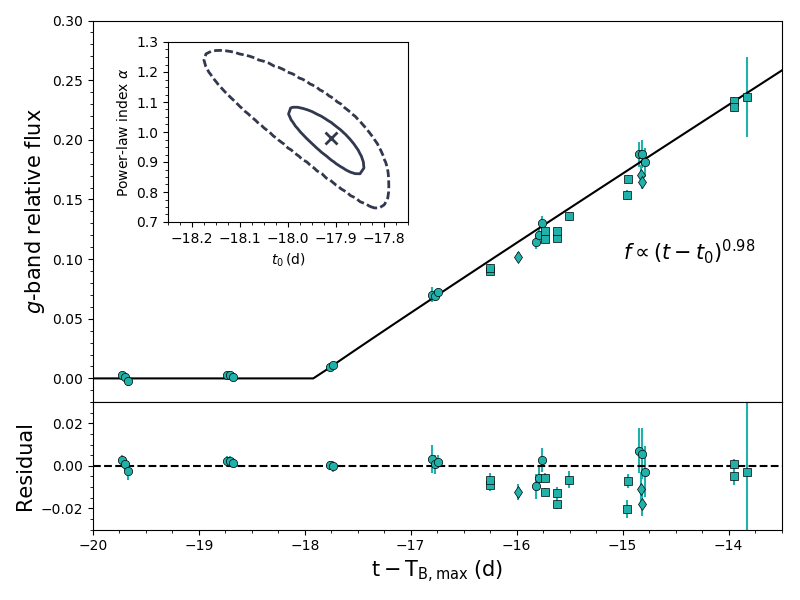

/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in power
  app.launch_new_instance()
/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


In [9]:
# make a nice plot for early data

fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(hspace=0.001)
ax = plt.subplot2grid([4, 1], [0, 0], rowspan=3)
res = plt.subplot2grid([4, 1], [3, 0])
for tel in ["P48", "P60", "LCO-1m"]:
    tel_obs = np.where(g_lc["telescope"] == tel.encode('UTF-8'))
    ax.errorbar(g_lc["time"][tel_obs], g_lc["flux"][tel_obs] * 1e3, 
                yerr=g_lc["flux_err"][tel_obs] * 1e3, 
                linestyle="none",
                marker=markers[tel],
                markersize=6,
                mec = 'k',
                mew = 0.5,
                color=AAMcolors['g'])

    res.errorbar(g_lc["time"][tel_obs], 
                 (g_lc["flux"][tel_obs] - 
                  EarlyLCModel(g_lc["time"][tel_obs], best_fit["t0"], best_fit["alpha"], best_fit["C"])) * 1e3,
                 yerr=g_lc["flux_err"][tel_obs] * 1e3,
                 linestyle="none",
                 marker=markers[tel], 
                 markersize=6,
                 mec = 'k', 
                 mew = 0.5,
                 color=AAMcolors['g'])


    
t = np.linspace(-3, 10, 101) + best_fit["t0"]
ax.plot(t, 
        EarlyLCModel(t, best_fit["t0"], best_fit["alpha"], best_fit["C"]) * 1e3, 
        'k-')
ax.text(-15, 0.10, "$f\\propto (t-t_0)^{%.2f}$" % best_fit["alpha"], fontsize=15)

ax.set_xticklabels([])
ax.set_yticks(np.arange(0, 0.5, 0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.01))
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.set_ylabel("$g$-band relative flux", fontsize=15)
ax.set_xlim(-20, -13.5)
ax.set_ylim(-0.02, 0.3)

res.set_xlim(ax.get_xlim())
res.set_ylim(-0.03, 0.03)
res.hlines(0, *(res.get_xlim()), linestyle='--')

res.set_xlabel(r"$\mathrm{t - T_{B,\mathrm{max}} \; (d)}$", fontsize=15)
res.set_ylabel("Residual", fontsize=15)
res.set_yticks([-0.02, 0, 0.02])
res.xaxis.set_minor_locator(MultipleLocator(0.25))
# res.set_yticks(np.arange(-.03, .03, 0.01))
res.yaxis.set_minor_locator(MultipleLocator(0.005))


inset = fig.add_axes([0.21, 0.63, 0.3, 0.3])
contour = inset.contour(X_2D, Y_2D, prob, [three_sigma, one_sigma],
                        colors=["#32384D", "#32384D"], linestyles=["--", "-"], linewidths=2)
inset.plot(best_fit["t0"], best_fit["alpha"], 'x', color="#32384D", linestyle='none', markersize=8, mew = 2)
inset.set_xlim(-18.25, -17.75)
inset.set_ylim(0.7, 1.3)
inset.set_xticks(np.arange(-18.2, -17.7, 0.1))
inset.set_xlabel("$t_0\\,\\rm{(d)}$")
inset.set_ylabel("Power-law index $\\alpha$")
inset.yaxis.set_minor_locator(MultipleLocator(0.025))
inset.yaxis.set_major_locator(MultipleLocator(0.1))
inset.xaxis.set_minor_locator(MultipleLocator(0.025))


fig.tight_layout()
fig.subplots_adjust(wspace=0,hspace=0)
# fig.subplots_adjust(top = 0.98, left = 0.1,bottom = 0.1, right = 0.97)
plt.savefig("early_lc.pdf")

Check that fitting all the early data does not significantly change the fit

In [24]:
idx = np.logical_and(g_lc["time"] > -21, g_lc["time"] < -13.5)
early_lc_all = g_lc[idx]


# set searching grids
t0_range = np.linspace(-19, -17, 201)
alpha_range = np.linspace(0.5, 2.5, 101)
C_range = np.linspace(-6, -3, 301)
X, Y, Z = np.meshgrid(t0_range, alpha_range, C_range)
chi2 = np.zeros(X.shape)
timegrid = np.ones(X.shape)
for t, f, ferr in zip(early_lc_all["time"], early_lc_all["flux"], early_lc_all["flux_err"]):
    chi2 += ((f - EarlyLCModel(t * timegrid, X, Y, Z))/ferr)**2
chi2 -= np.min(chi2)
idx = np.where(chi2 == 0.0)
best_fit_all = {"t0": X[idx], "alpha": Y[idx], "C": Z[idx]}
print(best_fit_all)

/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in power
  app.launch_new_instance()


{'t0': array([-18.06]), 'alpha': array([ 1.14]), 'C': array([-4.34])}


In [26]:
prob_all = np.sum(np.exp(-chi2 / 2), axis=2)
prob_all /= np.sum(prob_all)
X_2D, Y_2D = np.meshgrid(t0_range, alpha_range)

flat_prob_all = prob_all.flatten()
flat_prob_all.sort()
total = 0
one_sigma_all = -1
three_sigma_all = -1
for num in flat_prob_all[::-1]:
    total += num
    if one_sigma_all < 0 and total > 0.6827:
        one_sigma_all = num
    if three_sigma_all < 0 and total > 0.997:
        three_sigma_all = num

The 3-sigma contour is consistent with the 3-sigma contour for using only the P48 data.